# 01 - Exploration: Match Embeddings to Wetland Labels

Load pre-computed VAE embeddings and match them to wetland labels from preprocessing.

**Goal:** Create datasets ready for training classifiers.

**Inputs:**
- VAE embeddings: `data/processed/vae_embeddings_1M.npz`
- Wetland labels (both):
  - Proportion-based: `wetland_proportion_labeled.npz`
  - Hotspot-based: `wetland_hotspot_labeled.npz`

**Outputs:**
- `data/processed/embeddings_with_wetland_labels_proportion.npz`
- `data/processed/embeddings_with_wetland_labels_hotspot.npz`

## Setup

In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Add backbone to path
project_root = Path.cwd().parent.parent.parent
sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")
print(f"Current project: {Path.cwd().parent.name}")

Project root: c:\Users\Arnav\Documents\Python Scripts\bird embeddings
Current project: wetland_prediction


## 1. Load VAE Embeddings

In [2]:
# Load pre-computed VAE embeddings from backbone
embeddings_path = project_root / 'data' / 'processed' / 'kerala_embeddings_20251206_2156.npz'

print(f'Loading VAE embeddings from: {embeddings_path}')
embeddings_data = np.load(embeddings_path, allow_pickle=True)

# Extract data
embeddings = embeddings_data['embeddings']  # (N, latent_dim)
sampling_event_ids = embeddings_data['sampling_event_ids']  # (N,)

print(f'\n✓ Loaded embeddings:')
print(f'  Shape: {embeddings.shape}')
print(f'  Latent dimensions: {embeddings.shape[1]}')
print(f'  Number of checklists: {len(sampling_event_ids):,}')
print(f'\nEmbedding statistics:')
print(f'  Mean: {embeddings.mean():.4f}')
print(f'  Std: {embeddings.std():.4f}')
print(f'  Min: {embeddings.min():.4f}')
print(f'  Max: {embeddings.max():.4f}')

Loading VAE embeddings from: c:\Users\Arnav\Documents\Python Scripts\bird embeddings\data\processed\kerala_embeddings_20251206_2156.npz

✓ Loaded embeddings:
  Shape: (64895, 16)
  Latent dimensions: 16
  Number of checklists: 64,895

Embedding statistics:
  Mean: 0.0046
  Std: 0.4742
  Min: -4.2692
  Max: 5.0895


## 2. Load Wetland Labels - Proportion-based

In [3]:
# Load proportion-based labels
proportion_labels_path = Path('../data/processed/wetland_proportion_labeled.npz')

print(f'Loading proportion-based labels from: {proportion_labels_path}')
proportion_data = np.load(proportion_labels_path, allow_pickle=True)

# Extract data
prop_sampling_ids = proportion_data['sampling_event_ids']
prop_labels = proportion_data['labels']
prop_wetland_proportion = proportion_data['wetland_proportion']

print(f'\n✓ Loaded proportion-based labels:')
print(f'  Total labeled checklists: {len(prop_sampling_ids):,}')
print(f'  Wetland: {(prop_labels == "wetland").sum():,}')
print(f'  Non-wetland: {(prop_labels == "non-wetland").sum():,}')
print(f'\nMetadata:')
print(f'  Threshold: {proportion_data["threshold"]:.0%}')
print(f'  Wetland species count: {proportion_data["n_wetland_species"]}')

Loading proportion-based labels from: ..\data\processed\wetland_proportion_labeled.npz

✓ Loaded proportion-based labels:
  Total labeled checklists: 34,694
  Wetland: 17,347
  Non-wetland: 17,347

Metadata:
  Threshold: 30%
  Wetland species count: 50


## 3. Load Wetland Labels - Hotspot-based

In [4]:
# Load hotspot-based labels
hotspot_labels_path = Path('../data/processed/wetland_hotspot_labeled.npz')

print(f'Loading hotspot-based labels from: {hotspot_labels_path}')
hotspot_data = np.load(hotspot_labels_path, allow_pickle=True)

# Extract data
hot_sampling_ids = hotspot_data['sampling_event_ids']
hot_labels = hotspot_data['labels']
hot_locality_ids = hotspot_data['locality_ids']

print(f'\n✓ Loaded hotspot-based labels:')
print(f'  Total labeled checklists: {len(hot_sampling_ids):,}')
print(f'  Wetland: {(hot_labels == "wetland").sum():,}')
print(f'  Non-wetland: {(hot_labels == "non-wetland").sum():,}')
print(f'\nMetadata:')
print(f'  Method: {hotspot_data["method"]}')
print(f'  Wetland keywords: {hotspot_data["n_wetland_keywords"]}')
print(f'  Non-wetland keywords: {hotspot_data["n_non_wetland_keywords"]}')

Loading hotspot-based labels from: ..\data\processed\wetland_hotspot_labeled.npz

✓ Loaded hotspot-based labels:
  Total labeled checklists: 4,947
  Wetland: 2,102
  Non-wetland: 2,845

Metadata:
  Method: hotspot_name_heuristic
  Wetland keywords: 35
  Non-wetland keywords: 29


## 4. Match Embeddings to Labels - Proportion-based

In [5]:
# Create mapping from sampling event ID to embedding index
embedding_id_to_idx = {sid: idx for idx, sid in enumerate(sampling_event_ids)}

print(f'Created mapping for {len(embedding_id_to_idx):,} embeddings')

Created mapping for 64,895 embeddings


In [6]:
# Match proportion labels to embeddings
prop_matched_indices = []
prop_matched_labels = []
prop_matched_ids = []
prop_matched_proportions = []

for i, sid in enumerate(prop_sampling_ids):
    if sid in embedding_id_to_idx:
        prop_matched_indices.append(embedding_id_to_idx[sid])
        prop_matched_labels.append(prop_labels[i])
        prop_matched_ids.append(sid)
        prop_matched_proportions.append(prop_wetland_proportion[i])

# Convert to arrays
prop_matched_indices = np.array(prop_matched_indices)
prop_matched_labels = np.array(prop_matched_labels)
prop_matched_ids = np.array(prop_matched_ids)
prop_matched_proportions = np.array(prop_matched_proportions)

# Extract matched embeddings
prop_matched_embeddings = embeddings[prop_matched_indices]

print(f'Proportion-based matching results:')
print(f'  Labeled checklists: {len(prop_sampling_ids):,}')
print(f'  Matched with embeddings: {len(prop_matched_indices):,}')
print(f'  Match rate: {len(prop_matched_indices) / len(prop_sampling_ids) * 100:.1f}%')
print(f'\nMatched label distribution:')
print(f'  Wetland: {(prop_matched_labels == "wetland").sum():,}')
print(f'  Non-wetland: {(prop_matched_labels == "non-wetland").sum():,}')

Proportion-based matching results:
  Labeled checklists: 34,694
  Matched with embeddings: 29,991
  Match rate: 86.4%

Matched label distribution:
  Wetland: 15,010
  Non-wetland: 14,981


## 5. Match Embeddings to Labels - Hotspot-based

In [7]:
# Match hotspot labels to embeddings
hot_matched_indices = []
hot_matched_labels = []
hot_matched_ids = []
hot_matched_locality_ids = []

for i, sid in enumerate(hot_sampling_ids):
    if sid in embedding_id_to_idx:
        hot_matched_indices.append(embedding_id_to_idx[sid])
        hot_matched_labels.append(hot_labels[i])
        hot_matched_ids.append(sid)
        hot_matched_locality_ids.append(hot_locality_ids[i])

# Convert to arrays
hot_matched_indices = np.array(hot_matched_indices)
hot_matched_labels = np.array(hot_matched_labels)
hot_matched_ids = np.array(hot_matched_ids)
hot_matched_locality_ids = np.array(hot_matched_locality_ids)

# Extract matched embeddings
hot_matched_embeddings = embeddings[hot_matched_indices]

print(f'Hotspot-based matching results:')
print(f'  Labeled checklists: {len(hot_sampling_ids):,}')
print(f'  Matched with embeddings: {len(hot_matched_indices):,}')
print(f'  Match rate: {len(hot_matched_indices) / len(hot_sampling_ids) * 100:.1f}%')
print(f'\nMatched label distribution:')
print(f'  Wetland: {(hot_matched_labels == "wetland").sum():,}')
print(f'  Non-wetland: {(hot_matched_labels == "non-wetland").sum():,}')

Hotspot-based matching results:
  Labeled checklists: 4,947
  Matched with embeddings: 3,760
  Match rate: 76.0%

Matched label distribution:
  Wetland: 1,314
  Non-wetland: 2,446


## 6. Visualize Embedding Distributions by Label

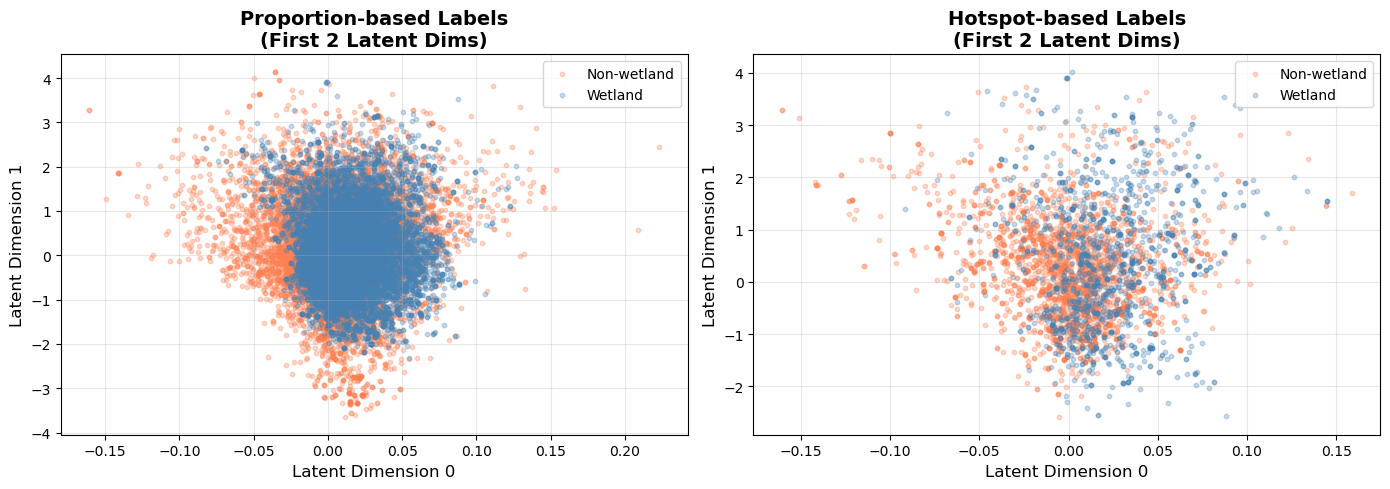

In [8]:
# Visualize proportion-based vs hotspot-based
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# First 2 latent dimensions - Proportion
wetland_mask = prop_matched_labels == 'wetland'
axes[0].scatter(
    prop_matched_embeddings[~wetland_mask, 0], 
    prop_matched_embeddings[~wetland_mask, 1],
    alpha=0.3, s=10, label='Non-wetland', color='coral'
)
axes[0].scatter(
    prop_matched_embeddings[wetland_mask, 0], 
    prop_matched_embeddings[wetland_mask, 1],
    alpha=0.3, s=10, label='Wetland', color='steelblue'
)
axes[0].set_xlabel('Latent Dimension 0', fontsize=12)
axes[0].set_ylabel('Latent Dimension 1', fontsize=12)
axes[0].set_title('Proportion-based Labels\n(First 2 Latent Dims)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# First 2 latent dimensions - Hotspot
wetland_mask_hot = hot_matched_labels == 'wetland'
axes[1].scatter(
    hot_matched_embeddings[~wetland_mask_hot, 0], 
    hot_matched_embeddings[~wetland_mask_hot, 1],
    alpha=0.3, s=10, label='Non-wetland', color='coral'
)
axes[1].scatter(
    hot_matched_embeddings[wetland_mask_hot, 0], 
    hot_matched_embeddings[wetland_mask_hot, 1],
    alpha=0.3, s=10, label='Wetland', color='steelblue'
)
axes[1].set_xlabel('Latent Dimension 0', fontsize=12)
axes[1].set_ylabel('Latent Dimension 1', fontsize=12)
axes[1].set_title('Hotspot-based Labels\n(First 2 Latent Dims)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

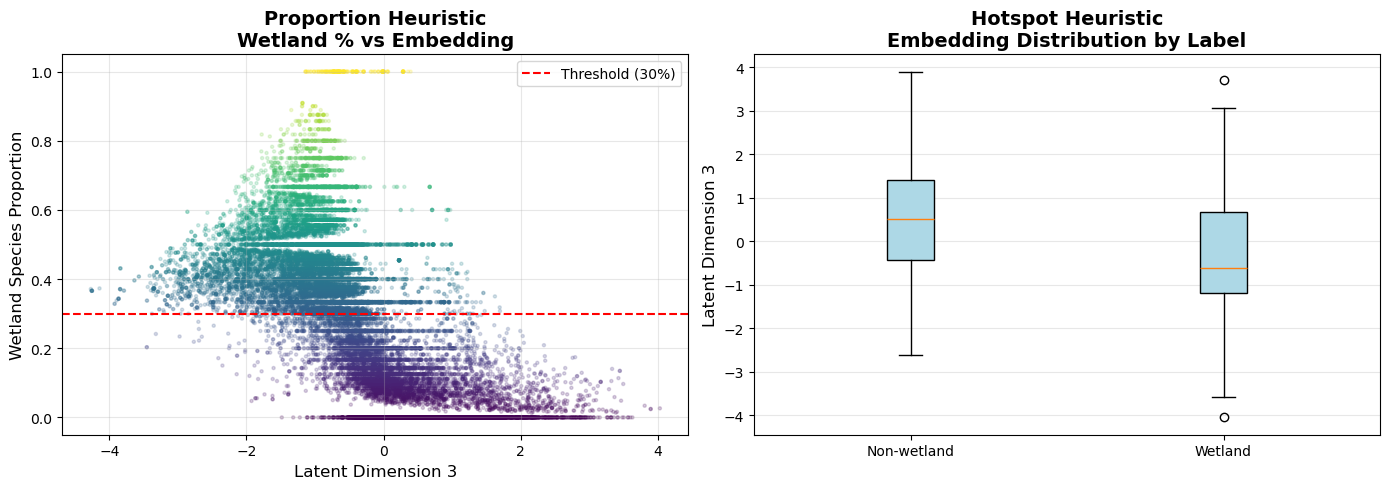

In [20]:
# Distribution of wetland proportion vs fourth latent dimension
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Proportion-based
axes[0].scatter(
    prop_matched_embeddings[:, 3],
    prop_matched_proportions,
    alpha=0.2, s=5, c=prop_matched_proportions, cmap='viridis'
)
axes[0].set_xlabel('Latent Dimension 3', fontsize=12)
axes[0].set_ylabel('Wetland Species Proportion', fontsize=12)
axes[0].set_title('Proportion Heuristic\nWetland % vs Embedding', fontsize=14, fontweight='bold')
axes[0].axhline(y=0.3, color='red', linestyle='--', label='Threshold (30%)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Hotspot-based - box plot by label
wetland_embeddings_hot = hot_matched_embeddings[hot_matched_labels == 'wetland', 3]
non_wetland_embeddings_hot = hot_matched_embeddings[hot_matched_labels == 'non-wetland', 3]

axes[1].boxplot(
    [non_wetland_embeddings_hot, wetland_embeddings_hot],
    labels=['Non-wetland', 'Wetland'],
    patch_artist=True,
    boxprops=dict(facecolor='lightblue')
)
axes[1].set_ylabel('Latent Dimension 3', fontsize=12)
axes[1].set_title('Hotspot Heuristic\nEmbedding Distribution by Label', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Save Matched Datasets for Training

In [10]:
# Create output directory
output_path = Path('../data/processed')
output_path.mkdir(parents=True, exist_ok=True)

# Save proportion-based dataset
prop_save_path = output_path / 'embeddings_with_wetland_labels_proportion.npz'

np.savez_compressed(
    prop_save_path,
    embeddings=prop_matched_embeddings,
    labels=prop_matched_labels,
    sampling_event_ids=prop_matched_ids,
    wetland_proportions=prop_matched_proportions,
    # Metadata
    latent_dim=embeddings.shape[1],
    n_samples=len(prop_matched_embeddings),
    labeling_method='proportion_heuristic',
    threshold=proportion_data['threshold']
)

print(f'✓ Saved proportion-based dataset:')
print(f'  Path: {prop_save_path}')
print(f'  Samples: {len(prop_matched_embeddings):,}')
print(f'  Wetland: {(prop_matched_labels == "wetland").sum():,}')
print(f'  Non-wetland: {(prop_matched_labels == "non-wetland").sum():,}')
print(f'  File size: {prop_save_path.stat().st_size / 1024 / 1024:.2f} MB')

✓ Saved proportion-based dataset:
  Path: ..\data\processed\embeddings_with_wetland_labels_proportion.npz
  Samples: 29,991
  Wetland: 15,010
  Non-wetland: 14,981
  File size: 1.93 MB


In [11]:
# Save hotspot-based dataset
hot_save_path = output_path / 'embeddings_with_wetland_labels_hotspot.npz'

np.savez_compressed(
    hot_save_path,
    embeddings=hot_matched_embeddings,
    labels=hot_matched_labels,
    sampling_event_ids=hot_matched_ids,
    locality_ids=hot_matched_locality_ids,
    # Metadata
    latent_dim=embeddings.shape[1],
    n_samples=len(hot_matched_embeddings),
    labeling_method='hotspot_name_heuristic',
    n_wetland_keywords=hotspot_data['n_wetland_keywords'],
    n_non_wetland_keywords=hotspot_data['n_non_wetland_keywords']
)

print(f'✓ Saved hotspot-based dataset:')
print(f'  Path: {hot_save_path}')
print(f'  Samples: {len(hot_matched_embeddings):,}')
print(f'  Wetland: {(hot_matched_labels == "wetland").sum():,}')
print(f'  Non-wetland: {(hot_matched_labels == "non-wetland").sum():,}')
print(f'  File size: {hot_save_path.stat().st_size / 1024 / 1024:.2f} MB')

✓ Saved hotspot-based dataset:
  Path: ..\data\processed\embeddings_with_wetland_labels_hotspot.npz
  Samples: 3,760
  Wetland: 1,314
  Non-wetland: 2,446
  File size: 0.19 MB


## Summary

In [12]:
print('='*70)
print('EXPLORATION COMPLETE')
print('='*70)
print(f'\n📊 Created 2 datasets for training:')
print(f'\n1. PROPORTION-BASED ({len(prop_matched_embeddings):,} samples)')
print(f'   File: embeddings_with_wetland_labels_proportion.npz')
print(f'   Wetland: {(prop_matched_labels == "wetland").sum():,} ({(prop_matched_labels == "wetland").sum() / len(prop_matched_labels) * 100:.1f}%)')
print(f'   Non-wetland: {(prop_matched_labels == "non-wetland").sum():,} ({(prop_matched_labels == "non-wetland").sum() / len(prop_matched_labels) * 100:.1f}%)')
print(f'   Method: ≥30% wetland species')
print(f'\n2. HOTSPOT-BASED ({len(hot_matched_embeddings):,} samples)')
print(f'   File: embeddings_with_wetland_labels_hotspot.npz')
print(f'   Wetland: {(hot_matched_labels == "wetland").sum():,} ({(hot_matched_labels == "wetland").sum() / len(hot_matched_labels) * 100:.1f}%)')
print(f'   Non-wetland: {(hot_matched_labels == "non-wetland").sum():,} ({(hot_matched_labels == "non-wetland").sum() / len(hot_matched_labels) * 100:.1f}%)')
print(f'   Method: Hotspot name keywords')
print(f'\n📐 Embedding dimensions: {embeddings.shape[1]}')
print(f'\n✨ Ready for Phase 2: Analysis!')
print('   Next: Run 02_analysis.ipynb to train Random Forest models')
print('='*70)

EXPLORATION COMPLETE

📊 Created 2 datasets for training:

1. PROPORTION-BASED (29,991 samples)
   File: embeddings_with_wetland_labels_proportion.npz
   Wetland: 15,010 (50.0%)
   Non-wetland: 14,981 (50.0%)
   Method: ≥30% wetland species

2. HOTSPOT-BASED (3,760 samples)
   File: embeddings_with_wetland_labels_hotspot.npz
   Wetland: 1,314 (34.9%)
   Non-wetland: 2,446 (65.1%)
   Method: Hotspot name keywords

📐 Embedding dimensions: 16

✨ Ready for Phase 2: Analysis!
   Next: Run 02_analysis.ipynb to train Random Forest models


## 8. Create Intersection Dataset (Hotspot + Proportion)

In [13]:
# Create intersection dataset: hotspot-based labels verified by proportion
# Take hotspot-labeled checklists and filter by wetland bird proportion

print('Creating intersection dataset: Hotspot names + Bird proportion verification')
print('='*70)

# Load the wetland proportion data for ALL checklists
all_prop_sampling_ids = proportion_data['sampling_event_ids']
all_prop_proportions = proportion_data['wetland_proportion']

# Create a mapping from sampling_event_id to wetland proportion
prop_map = dict(zip(all_prop_sampling_ids, all_prop_proportions))

print(f'\nStarting with hotspot-labeled checklists: {len(hot_matched_ids):,}')
print(f'  Wetland (by hotspot name): {(hot_matched_labels == "wetland").sum():,}')
print(f'  Non-wetland (by hotspot name): {(hot_matched_labels == "non-wetland").sum():,}')

Creating intersection dataset: Hotspot names + Bird proportion verification

Starting with hotspot-labeled checklists: 3,760
  Wetland (by hotspot name): 1,314
  Non-wetland (by hotspot name): 2,446


In [14]:
# Filter hotspot wetlands: keep only those with high proportion of wetland birds (≥30%)
# Filter hotspot non-wetlands: keep only those with low proportion of wetland birds (<30%)

intersection_mask = []
intersection_labels = []

for i, (sid, label) in enumerate(zip(hot_matched_ids, hot_matched_labels)):
    if sid in prop_map:
        proportion = prop_map[sid]
        
        # Wetland hotspot must have ≥30% wetland birds
        if label == 'wetland' and proportion >= 0.30:
            intersection_mask.append(i)
            intersection_labels.append('wetland')
        # Non-wetland hotspot must have <30% wetland birds
        elif label == 'non-wetland' and proportion < 0.30:
            intersection_mask.append(i)
            intersection_labels.append('non-wetland')

intersection_mask = np.array(intersection_mask)
intersection_labels = np.array(intersection_labels)

# Filter the matched data
inter_matched_embeddings = hot_matched_embeddings[intersection_mask]
inter_matched_ids = hot_matched_ids[intersection_mask]
inter_matched_locality_ids = hot_matched_locality_ids[intersection_mask]
inter_matched_labels = intersection_labels

# Get proportions for these checklists
inter_matched_proportions = np.array([prop_map[sid] for sid in inter_matched_ids])

print(f'\n✓ Intersection dataset created:')
print(f'  Total samples: {len(inter_matched_embeddings):,}')
print(f'  Wetland: {(inter_matched_labels == "wetland").sum():,} ({(inter_matched_labels == "wetland").sum() / len(inter_matched_labels) * 100:.1f}%)')
print(f'  Non-wetland: {(inter_matched_labels == "non-wetland").sum():,} ({(inter_matched_labels == "non-wetland").sum() / len(inter_matched_labels) * 100:.1f}%)')
print(f'\nFiltering effect:')
print(f'  Kept {len(inter_matched_embeddings) / len(hot_matched_embeddings) * 100:.1f}% of hotspot-labeled checklists')
print(f'  Removed {len(hot_matched_embeddings) - len(inter_matched_embeddings):,} checklists where labels disagreed')


✓ Intersection dataset created:
  Total samples: 1,165
  Wetland: 574 (49.3%)
  Non-wetland: 591 (50.7%)

Filtering effect:
  Kept 31.0% of hotspot-labeled checklists
  Removed 2,595 checklists where labels disagreed


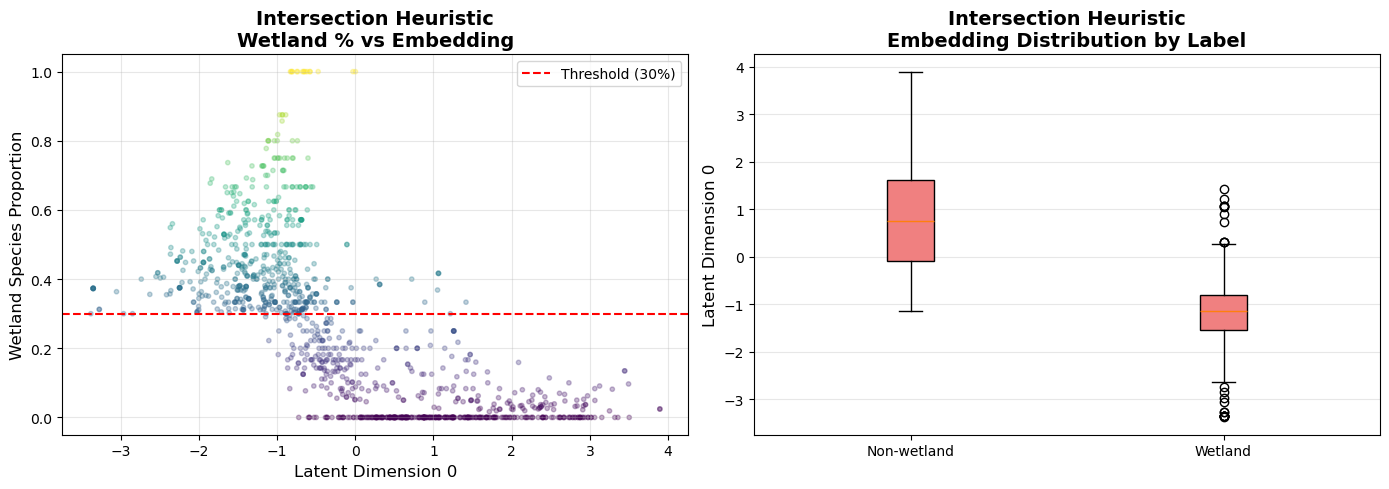


✓ Both heuristics agree on these labels!
  This should be the highest quality dataset.


In [21]:
# Visualize the intersection dataset
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter: Wetland proportion vs first latent dimension
axes[0].scatter(
    inter_matched_embeddings[:, 3],
    inter_matched_proportions,
    alpha=0.3, s=10, c=inter_matched_proportions, cmap='viridis'
)
axes[0].set_xlabel('Latent Dimension 0', fontsize=12)
axes[0].set_ylabel('Wetland Species Proportion', fontsize=12)
axes[0].set_title('Intersection Heuristic\nWetland % vs Embedding', fontsize=14, fontweight='bold')
axes[0].axhline(y=0.3, color='red', linestyle='--', label='Threshold (30%)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot by label
wetland_embeddings_inter = inter_matched_embeddings[inter_matched_labels == 'wetland', 3]
non_wetland_embeddings_inter = inter_matched_embeddings[inter_matched_labels == 'non-wetland', 3]

axes[1].boxplot(
    [non_wetland_embeddings_inter, wetland_embeddings_inter],
    labels=['Non-wetland', 'Wetland'],
    patch_artist=True,
    boxprops=dict(facecolor='lightcoral')
)
axes[1].set_ylabel('Latent Dimension 0', fontsize=12)
axes[1].set_title('Intersection Heuristic\nEmbedding Distribution by Label', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print('\n✓ Both heuristics agree on these labels!')
print('  This should be the highest quality dataset.')

In [16]:
# Save intersection dataset
inter_save_path = output_path / 'embeddings_with_wetland_labels_intersection.npz'

np.savez_compressed(
    inter_save_path,
    embeddings=inter_matched_embeddings,
    labels=inter_matched_labels,
    sampling_event_ids=inter_matched_ids,
    locality_ids=inter_matched_locality_ids,
    wetland_proportions=inter_matched_proportions,
    # Metadata
    latent_dim=embeddings.shape[1],
    n_samples=len(inter_matched_embeddings),
    labeling_method='intersection_heuristic',
    description='Hotspot name keywords verified by wetland bird proportion',
    threshold=0.30,
    n_wetland_keywords=hotspot_data['n_wetland_keywords'],
    n_non_wetland_keywords=hotspot_data['n_non_wetland_keywords']
)

print(f'✓ Saved intersection dataset:')
print(f'  Path: {inter_save_path}')
print(f'  Samples: {len(inter_matched_embeddings):,}')
print(f'  Wetland: {(inter_matched_labels == "wetland").sum():,}')
print(f'  Non-wetland: {(inter_matched_labels == "non-wetland").sum():,}')
print(f'  File size: {inter_save_path.stat().st_size / 1024 / 1024:.2f} MB')

✓ Saved intersection dataset:
  Path: ..\data\processed\embeddings_with_wetland_labels_intersection.npz
  Samples: 1,165
  Wetland: 574
  Non-wetland: 591
  File size: 0.07 MB


## Final Summary

In [17]:
print('='*70)
print('EXPLORATION COMPLETE')
print('='*70)
print(f'\n📊 Created 3 datasets for training:\n')

print(f'1. PROPORTION-BASED ({len(prop_matched_embeddings):,} samples)')
print(f'   File: embeddings_with_wetland_labels_proportion.npz')
print(f'   Wetland: {(prop_matched_labels == "wetland").sum():,} ({(prop_matched_labels == "wetland").sum() / len(prop_matched_labels) * 100:.1f}%)')
print(f'   Non-wetland: {(prop_matched_labels == "non-wetland").sum():,} ({(prop_matched_labels == "non-wetland").sum() / len(prop_matched_labels) * 100:.1f}%)')
print(f'   Method: ≥30% wetland species\n')

print(f'2. HOTSPOT-BASED ({len(hot_matched_embeddings):,} samples)')
print(f'   File: embeddings_with_wetland_labels_hotspot.npz')
print(f'   Wetland: {(hot_matched_labels == "wetland").sum():,} ({(hot_matched_labels == "wetland").sum() / len(hot_matched_labels) * 100:.1f}%)')
print(f'   Non-wetland: {(hot_matched_labels == "non-wetland").sum():,} ({(hot_matched_labels == "non-wetland").sum() / len(hot_matched_labels) * 100:.1f}%)')
print(f'   Method: Hotspot name keywords\n')

print(f'3. INTERSECTION ({len(inter_matched_embeddings):,} samples)')
print(f'   File: embeddings_with_wetland_labels_intersection.npz')
print(f'   Wetland: {(inter_matched_labels == "wetland").sum():,} ({(inter_matched_labels == "wetland").sum() / len(inter_matched_labels) * 100:.1f}%)')
print(f'   Non-wetland: {(inter_matched_labels == "non-wetland").sum():,} ({(inter_matched_labels == "non-wetland").sum() / len(inter_matched_labels) * 100:.1f}%)')
print(f'   Method: Hotspot names + Proportion verification\n')

print(f'📐 Embedding dimensions: {embeddings.shape[1]}')
print(f'\n✨ Ready for Phase 2: Analysis!')
print('   Next: Run 02_analysis.ipynb to train Random Forest models on all 3 datasets')
print('='*70)

EXPLORATION COMPLETE

📊 Created 3 datasets for training:

1. PROPORTION-BASED (29,991 samples)
   File: embeddings_with_wetland_labels_proportion.npz
   Wetland: 15,010 (50.0%)
   Non-wetland: 14,981 (50.0%)
   Method: ≥30% wetland species

2. HOTSPOT-BASED (3,760 samples)
   File: embeddings_with_wetland_labels_hotspot.npz
   Wetland: 1,314 (34.9%)
   Non-wetland: 2,446 (65.1%)
   Method: Hotspot name keywords

3. INTERSECTION (1,165 samples)
   File: embeddings_with_wetland_labels_intersection.npz
   Wetland: 574 (49.3%)
   Non-wetland: 591 (50.7%)
   Method: Hotspot names + Proportion verification

📐 Embedding dimensions: 16

✨ Ready for Phase 2: Analysis!
   Next: Run 02_analysis.ipynb to train Random Forest models on all 3 datasets
